In [1]:
!pip install tensorflow_text
!pip install -q tf-models-official==2.11.0
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 766.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 21

In [9]:
from google.colab import drive

drive.mount('/content/gdrive')
path = 'gdrive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
import os




In [6]:
import os
import re
import shutil
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

In [ ]:
import os
import re
import shutil
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

In [10]:
df_train = pd.read_csv(os.path.join(path,'', 'train.csv'))

In [ ]:
df_train = df_train.head(15000)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
df_train.shape

(159571, 8)

In [12]:
test_samples = pd.read_csv(os.path.join(path,'', 'test.csv'))
test_labels = pd.read_csv(os.path.join(path,'', 'test_labels.csv'))
df_test = pd.merge(test_samples, test_labels, on="id")

In [ ]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [ ]:
df_test.shape

(153164, 8)

In [13]:
# removing sample with labels equal to -1
df_test = df_test.loc[df_test['toxic'] >= 0]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [ ]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [ ]:
df_test.shape

(63978, 8)

In [ ]:
df_train[df_train.columns[2:]].iloc[0]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: int64

In [ ]:
#NON-TOXIC comment example
df_train.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df_train[df_train.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

In [ ]:
#TOXIC comment example
df_train.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [ ]:
for label in df_train.columns[2:]:
    print(df_train[label].value_counts(), '\n')

0    144277
1     15294
Name: toxic, dtype: int64 

0    157976
1      1595
Name: severe_toxic, dtype: int64 

0    151122
1      8449
Name: obscene, dtype: int64 

0    159093
1       478
Name: threat, dtype: int64 

0    151694
1      7877
Name: insult, dtype: int64 

0    158166
1      1405
Name: identity_hate, dtype: int64 



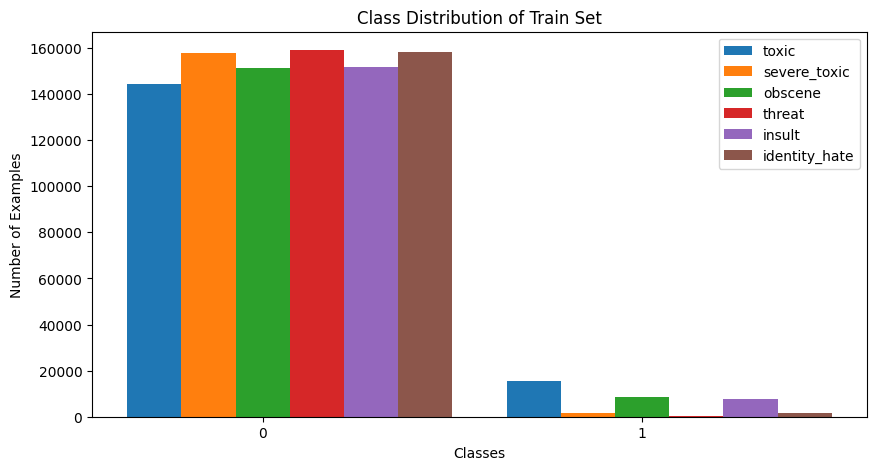

In [ ]:
# Get the class distribution for each column
class_distributions = []
for i in range(2, 8):
    class_distributions.append(df_train.iloc[:, i].value_counts())

# Create a combined bar chart
labels = class_distributions[0].index
num_columns = len(class_distributions)
width = 1 / (num_columns + 1)

fig, ax = plt.subplots(figsize=(10, 5))

for i, class_dist in enumerate(class_distributions):
    x = np.arange(len(labels)) + (i + 1) * width
    bars = ax.bar(x, class_dist, width, label=df_train.columns[i+2])

ax.set_ylabel('Number of Examples')
ax.set_xlabel('Classes')
ax.set_title('Class Distribution of Train Set')
ax.set_xticks(x - width * (num_columns / 2))
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [ ]:
labels = df_train.columns[2:]
# Compute the class distribution for the train set
train_class_distribution = df_train.iloc[:, 2:].sum()

# Compute the class distribution for the test set
test_class_distribution = df_test.iloc[:, 2:].sum()

print('Positive labels distribution in train set in percentage (%)')
print(round(train_class_distribution/df_train.shape[0]*100,2).sort_values(ascending = False))
print()
print(print('Positive labels distribution in test set in percentage (%)'))
print(round(test_class_distribution/df_test.shape[0]*100,2).sort_values(ascending = False))

Positive labels distribution in train set in percentage (%)
toxic            9.58
obscene          5.29
insult           4.94
severe_toxic     1.00
identity_hate    0.88
threat           0.30
dtype: float64

Positive labels distribution in test set in percentage (%)
None
toxic            9.52
obscene          5.77
insult           5.36
identity_hate    1.11
severe_toxic     0.57
threat           0.33
dtype: float64


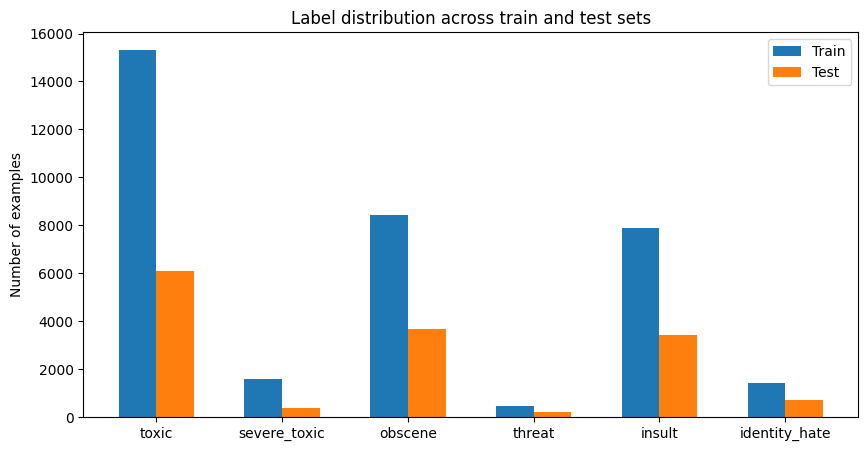

In [ ]:
train_data = [train_class_distribution[label] for label in labels]
test_data = [test_class_distribution[label] for label in labels]

# plot the bar chart
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 5))
train_bars = ax.bar(x - width/2, train_data, width, label='Train')
test_bars = ax.bar(x + width/2, test_data, width, label='Test')

# add labels, title and legend
ax.set_ylabel('Number of examples')
ax.set_title('Label distribution across train and test sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# display the plot
plt.show()

In [ ]:
train_class_distribution.sort_values(ascending = False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [ ]:
print('Distribution among only positive labels in train set in percentage (%)')
print(round(train_class_distribution/train_class_distribution.sum()*100,2).sort_values(ascending = False))
print()
print('Distribution among only positive labels in test set in percentage (%)')
print(round(test_class_distribution/test_class_distribution.sum()*100,2).sort_values(ascending = False))

Distribution among only positive labels in train set in percentage (%)
toxic            43.58
obscene          24.07
insult           22.44
severe_toxic      4.54
identity_hate     4.00
threat            1.36
dtype: float64

Distribution among only positive labels in test set in percentage (%)
toxic            42.01
obscene          25.46
insult           23.64
identity_hate     4.91
severe_toxic      2.53
threat            1.46
dtype: float64


In [35]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1' # add the missing key-value pair
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1' # add the missing key-value pair
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [36]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [37]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [38]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [39]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626294   0.9928099  -0.18611868  0.3667384   0.15233697  0.6550447
  0.9681154  -0.94862723  0.00216173 -0.9877732   0.06842681 -0.97630596]


In [40]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [41]:
tf.keras.backend.clear_session()
classifier_model = build_classifier_model()


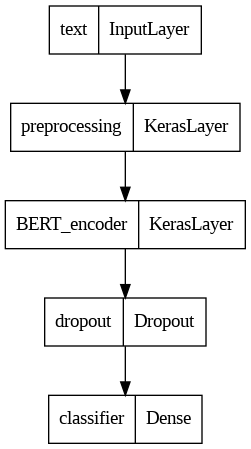

In [42]:
tf.keras.utils.plot_model(classifier_model)

In [43]:
y = df_train[df_train.columns[2:]]
ds= tf.data.Dataset.from_tensor_slices((df_train['comment_text'], y))
ds = ds.cache()
ds = ds.shuffle(160000)
ds = ds.batch(32)
ds = ds.prefetch(16) 

In [44]:
train_ds = ds.take(int(len(ds)*.8))
val_ds = ds.skip(int(len(ds)*.8)).take(int(len(ds)*.2))

In [45]:
y_test = df_test[df_test.columns[2:]]
test= tf.data.Dataset.from_tensor_slices((df_test['comment_text'], y_test))
test = test.cache()
test = test.batch(32)
test = test.prefetch(16) 

In [46]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [47]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])

## Training the model

In [48]:
print(f'Training model with {tfhub_handle_encoder}')
checkpoint_filepath = 'drive/MyDrive/tmp_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = classifier_model.fit(x=train_ds,
                               
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks = [model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
  10/3989 [..............................] - ETA: 8:51:33 - loss: 0.9672 - f1_score: 0.0481

KeyboardInterrupt: ignored

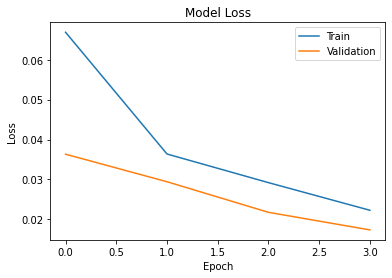

In [ ]:
# Plot the loss and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

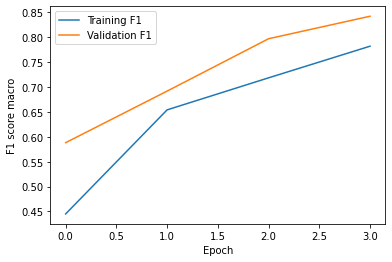

In [ ]:
# Plot the F1 macro score on the training and validation sets
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
plt.show()

## Evaluating the model

In [ ]:
# restoring the best weights for BERT model
model_glove.load_weights('drive/MyDrive/toxicity_bert.h5')

In [ ]:
from sklearn.metrics import classification_report
# Predict the labels for all batches in your test dataset
y_pred = []
y_true = []
label_names = df_train.columns[2:]

for X_batch, y_batch in test:
    y_pred_batch = classifier_model.predict(X_batch)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch)

# Convert the predicted and true labels into numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 [==============================] - 1s 771ms/step


In [ ]:
threshold = 0.5
y_pred_thresh = (y_pred >= threshold).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_thresh, target_names=label_names, zero_division = 1)
print(report)

               precision    recall  f1-score   support

        toxic       0.54      0.90      0.67      6090
 severe_toxic       0.34      0.56      0.42       367
      obscene       0.62      0.80      0.70      3691
       threat       0.51      0.70      0.59       211
       insult       0.66      0.75      0.70      3427
identity_hate       0.59      0.65      0.62       712

    micro avg       0.58      0.82      0.67     14498
    macro avg       0.54      0.73      0.62     14498
 weighted avg       0.58      0.82      0.68     14498
  samples avg       0.92      0.98      0.90     14498



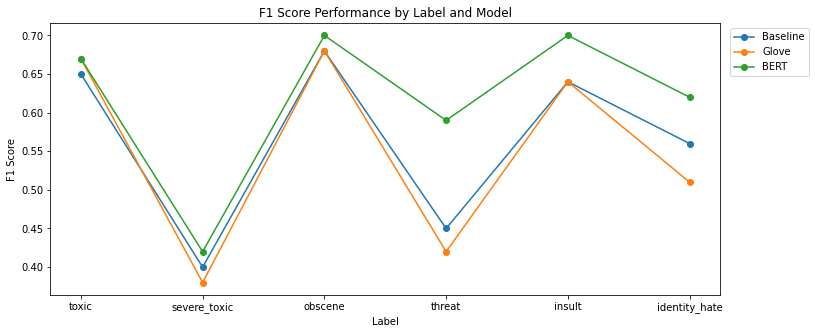

In [ ]:
import matplotlib.pyplot as plt

# define the labels and f1 scores for each model
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
f1_scores_model1 = [0.65, 0.40, 0.68, 0.45, 0.64, 0.56]
f1_scores_model2 = [0.67, 0.38, 0.68, 0.42, 0.64, 0.51]
f1_scores_model3 = [0.67, 0.42, 0.70, 0.59, 0.70, 0.62]

# create a list of x values for each label
x_values = list(range(len(labels)))

plt.figure(figsize=(12,5))
# plot the f1 scores for each model
plt.plot(x_values, f1_scores_model1, 'o-', label='Baseline')
plt.plot(x_values, f1_scores_model2, 'o-', label='Glove')
plt.plot(x_values, f1_scores_model3, 'o-', label='BERT')

# set the x-axis labels to the label names
plt.xticks(x_values, labels)

# add a legend
plt.legend()

# set the title and axis labels
plt.title('F1 Score Performance by Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1.14, 1), loc='upper right')
# display the plot
plt.show()

    